In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

import wrf

In [2]:
xr.set_options(display_style='text') 

# Functions, data

In [3]:
def extract_wrfout(simulation_path,nfiles=70):
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=70):
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [4]:
deepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfinput_d01')
deepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc')


In [5]:
lmdeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfinput_d01')
lmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
lmdeepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
#lmdeepchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.precip.days0-200.nc')


In [6]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
dryhrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')


In [6]:
hrhgt = deepinput.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-deepinput.west_east)*3
def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()
def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})



## computing diagnostics

In [7]:
from dask.distributed import Client
client = Client()

In [9]:
import wrf
def compute_individual_cape_2(dsinput,ds):
    pres_hpa = (ds.P+dsinput.PB).transpose('Time','bottom_top','south_north','west_east')/100
    tkel = ((300+ds.T)*(pres_hpa/1e3)**0.286).transpose('Time','bottom_top','south_north','west_east')
    height=wrf.destagger((dsinput.PHB+ds.PH).transpose('Time','bottom_top_stag','south_north','west_east'),1)/9.81
    return wrf.cape_2d(pres_hpa, tkel, ds.QVAPOR, height, ds.HGT, ds.PSFC/100, ter_follow=True)

In [10]:
for file in sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout*')):
    print(file)
    c = compute_individual_cape_2(deepinput.isel(Time=0),xr.open_dataset(file))
    c.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.cape.'+file[-19:]+'.nc')
    

/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-01-01_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-01-11_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-01-21_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-01-31_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-02-10_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-02-20_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-02-20_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-03-02_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfout_d01_1970-03-12_0

In [11]:
for file in sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout*')):
    print(file)
    c = compute_individual_cape_2(deepinput.isel(Time=0),xr.open_dataset(file))
    c.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.cape.'+file[-19:]+'.nc')
    

/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-01-01_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-01-11_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-01-21_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-01-31_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-02-10_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-02-20_00_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-02-20_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfout_d01_1970-03-02_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mo

In [ ]:
deepchannelprecip = 4*(deepchannel.RAINNC).diff('Time')
%time deepchannelprecip.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc')

CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 12.3 ms


In [ ]:
%%time 
deepchannelprecip_hourly = 24*(deepchannel_p.RAINNC).diff('Time')
deepchannelprecip_hourly.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.hourly.days0-250.nc')

In [6]:
deepwmean_s = deepchannel.W.isel(Time=slice(400,1001)).mean(['Time','south_north'])
%time deepwmean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.W.days100-250.nc')


CPU times: user 4.23 s, sys: 445 ms, total: 4.67 s
Wall time: 54.9 s


In [ ]:
deepumean  =deepchannel_p.U_PL.isel(Time=slice(2400,6001)).mean(['Time','south_north'])
deepwmean  =deepchannel_p.W_PL.isel(Time=slice(2400,6001)).mean(['Time','south_north'])
deeprhomean=deepchannel_p.RHO_PL.isel(Time=slice(2400,6001)).mean(['Time','south_north'])
deeptmean  =deepchannel_p.T_PL.isel(Time=slice(2400,6001)).mean(['Time','south_north'])
deepqmean  =deepchannel_p.Q_PL.isel(Time=slice(2400,6001)).mean(['Time','south_north'])
%time deepumean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.U_PL.days100-250.nc')
%time deepwmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.W_PL.days100-250.nc')
%time deeprhomean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.RHO_PL.days100-250.nc')
%time deeptmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc')
%time deepqmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.Q_PL.days100-250.nc')


CPU times: user 2min 25s, sys: 11min 56s, total: 14min 21s
Wall time: 8min 52s
CPU times: user 2min 13s, sys: 11min 35s, total: 13min 48s
Wall time: 8min 45s
CPU times: user 2min 19s, sys: 13min 5s, total: 15min 24s
Wall time: 9min 32s


In [37]:
lmdeepchannelprecip = 4*(lmdeepchannel.RAINNC).diff('Time')
%time lmdeepchannelprecip.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.precip.days0-200.nc')

CPU times: user 2.86 s, sys: 1.42 s, total: 4.29 s
Wall time: 25 s


In [38]:
%%time 
lmdeepchannelprecip_hourly = 24*(lmdeepchannel_p.RAINNC).diff('Time')
lmdeepchannelprecip_hourly.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.precip.hourly.days0-200.nc')

CPU times: user 7.84 s, sys: 6.09 s, total: 13.9 s
Wall time: 1min 56s


In [6]:
lmdeepwmean_s = lmdeepchannel.W.isel(Time=slice(200,801)).mean(['Time','south_north'])
%time lmdeepwmean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.W.days50-200.nc')


CPU times: user 50.9 s, sys: 1min 57s, total: 2min 48s
Wall time: 2min 16s


In [7]:
lmdeepumean  =lmdeepchannel_p.U_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north'])
lmdeepwmean  =lmdeepchannel_p.W_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north'])
lmdeeprhomean=lmdeepchannel_p.RHO_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north'])
lmdeeptmean  =lmdeepchannel_p.T_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north'])
lmdeepqmean  =lmdeepchannel_p.Q_PL.isel(Time=slice(1200,4801)).mean(['Time','south_north'])
%time lmdeepumean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.U_PL.days50-200.nc')
%time lmdeepwmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.W_PL.days50-200.nc')
%time lmdeeprhomean.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.RHO_PL.days50-200.nc')
%time lmdeeptmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.T_PL.days50-200.nc')
%time lmdeepqmean.to_netcdf(  '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.Q_PL.days50-200.nc')


CPU times: user 2min 41s, sys: 12min 26s, total: 15min 7s
Wall time: 10min 18s
CPU times: user 2min 38s, sys: 13min 54s, total: 16min 33s
Wall time: 10min 52s
CPU times: user 2min 34s, sys: 11min 54s, total: 14min 29s
Wall time: 10min 11s
CPU times: user 2min 37s, sys: 13min 22s, total: 15min 59s
Wall time: 11min 8s
CPU times: user 2min 44s, sys: 13min 17s, total: 16min 1s
Wall time: 10min 46s


## Pressure interpolation of dry variables

In [5]:
from netCDF4 import Dataset
import wrf

In [6]:
drydeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/wrfinput_d01')
drydeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/')

In [6]:
#drydeepw_s = drydeepchannel.W[201:].mean(['Time','south_north'])
#drydeepw_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.W.days50-100.nc')

In [ ]:
#drydeept_s = (drydeepchannel.T[201:]+300)*((drydeepinput.PB[0]+drydeepchannel.P[201:])/1e5)**0.286
#drydeept_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.TEMP.all.days50-100.nc')

In [9]:
plevs=np.array(deepchannel_p.P_PL.isel(Time=0).load())[::-1]/100

In [10]:
files = ['/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/wrfout_d01_1970-02-20_06_00_00',
         '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/wrfout_d01_1970-03-02_06_00_00',
         '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/wrfout_d01_1970-03-12_06_00_00',
         '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/wrfout_d01_1970-03-22_06_00_00',
         '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/wrfout_d01_1970-04-01_06_00_00']
dlist=[Dataset(file) for file in files]

In [11]:
drydeept_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.TEMP.all.days50-100.nc')

In [26]:
from scipy.interpolate import interp1d
def interp_eta_to_pressure_custom(ds,var,staggered=1,plevs=None,dsinput=None,PB_rev=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    if PB_rev is None:
        if dsinput is None:
            dsinput=ds
        PB_rev = np.array(dsinput.PB[0,:,0]+ds.P[-100:].mean(['Time','south_north']))[::-1]
    rep=np.zeros((len(plevs),*var[0].shape))
    var_rev=np.array(var)[::-1]
    if staggered:
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0,0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            f_out = interp1d(PB_rev_stag, var_rev[:,:,i], axis=0,bounds_error=False,fill_value=np.nan)
            rep[:,:,i]=f_out(plevs*100)
            rep[plevs*100>PB_rev_stag[-1],:,i]=np.nan
    else:
        for i in range(len(var[0,0])):
            f_out = interp1d(PB_rev[:,i], var_rev[:,:,i], axis=0,bounds_error=False,fill_value=np.nan)
            rep[:,:,i]=f_out(plevs*100)
            rep[plevs*100>PB_rev[-1,i],:,i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'south_north':var.south_north,'west_east':var.west_east},dims=['pressure','south_north','west_east'])



In [13]:
%%time
PB_rev_0 = np.array(drydeepinput.PB[0,:,0]+drydeepchannel.P[-100:].mean(['Time','south_north']))[::-1]
out = xr.DataArray(np.zeros((200,len(plevs),len(deepchannel.south_north),len(deepchannel.west_east))),coords={'Time':drydeept_s.Time,'pressure':plevs[::-1],'south_north':drydeept_s.south_north,'west_east':drydeept_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(drydeept_s.Time)):
    out[i]= interp_eta_to_pressure_custom(deepchannel,drydeept_s[i],staggered=0,plevs=plevs,PB_rev=PB_rev_0)
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.T_PL.all.days50-100.nc')
out.mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.T_PL.days50-100.nc')


CPU times: user 3min 15s, sys: 55.7 s, total: 4min 11s
Wall time: 4min 13s


In [18]:
drydeepu_s = drydeepchannel.U[201:]

In [19]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(deepchannel.south_north),len(deepchannel.west_east))),coords={'Time':drydeept_s.Time,'pressure':plevs[::-1],'south_north':drydeept_s.south_north,'west_east':drydeept_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(drydeept_s.Time)):
    out[i]= interp_eta_to_pressure_custom(deepchannel,wrf.destagger(drydeepu_s[i],2,meta=True),staggered=0,plevs=plevs,PB_rev=PB_rev_0)
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.U_PL.all.days50-100.nc')
out.mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.U_PL.days50-100.nc')


CPU times: user 3min 25s, sys: 1min 6s, total: 4min 31s
Wall time: 4min 56s


In [20]:
drydeepw_s = drydeepchannel.W[201:]

In [27]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(deepchannel.south_north),len(deepchannel.west_east))),coords={'Time':drydeept_s.Time,'pressure':plevs[::-1],'south_north':drydeept_s.south_north,'west_east':drydeept_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(drydeept_s.Time)):
    out[i]= interp_eta_to_pressure_custom(deepchannel,drydeepw_s[i],staggered=1,plevs=plevs,PB_rev=PB_rev_0)
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.W_PL.all.days50-100.nc')
out.mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.W_PL.days50-100.nc')


CPU times: user 3min 51s, sys: 1min 20s, total: 5min 11s
Wall time: 5min 42s


In [22]:
drydeeprho_s = drydeepchannel.RHO[201:]

In [23]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(deepchannel.south_north),len(deepchannel.west_east))),coords={'Time':drydeept_s.Time,'pressure':plevs[::-1],'south_north':drydeept_s.south_north,'west_east':drydeept_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(drydeept_s.Time)):
    out[i]= interp_eta_to_pressure_custom(deepchannel,drydeeprho_s[i],staggered=0,plevs=plevs,PB_rev=PB_rev_0)
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.RHO_PL.all.days50-100.nc')
out.mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.RHO_PL.days50-100.nc')

CPU times: user 3min 21s, sys: 55.4 s, total: 4min 17s
Wall time: 4min 43s


In [24]:
drydeepq_s = drydeepchannel.QVAPOR[201:]

In [25]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(deepchannel.south_north),len(deepchannel.west_east))),coords={'Time':drydeept_s.Time,'pressure':plevs[::-1],'south_north':drydeept_s.south_north,'west_east':drydeept_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(drydeept_s.Time)):
    out[i]= interp_eta_to_pressure_custom(deepchannel,drydeepq_s[i],staggered=0,plevs=plevs,PB_rev=PB_rev_0)
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.Q_PL.all.days50-100.nc')
out.mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.Q_PL.days50-100.nc')


CPU times: user 3min 23s, sys: 1min 11s, total: 4min 35s
Wall time: 4min 57s


# Test of dry temp

In [15]:
dryt_s=change_coords_sfc(xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.TEMP.days50-100.nc"))


In [17]:
%time drydeept_s = change_coords_sfc(xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.TEMP.all.days50-100.nc').mean(['Time','south_north'])).load()


CPU times: user 12.3 s, sys: 21.1 s, total: 33.4 s
Wall time: 33.5 s


(-1000.0, 1000.0)

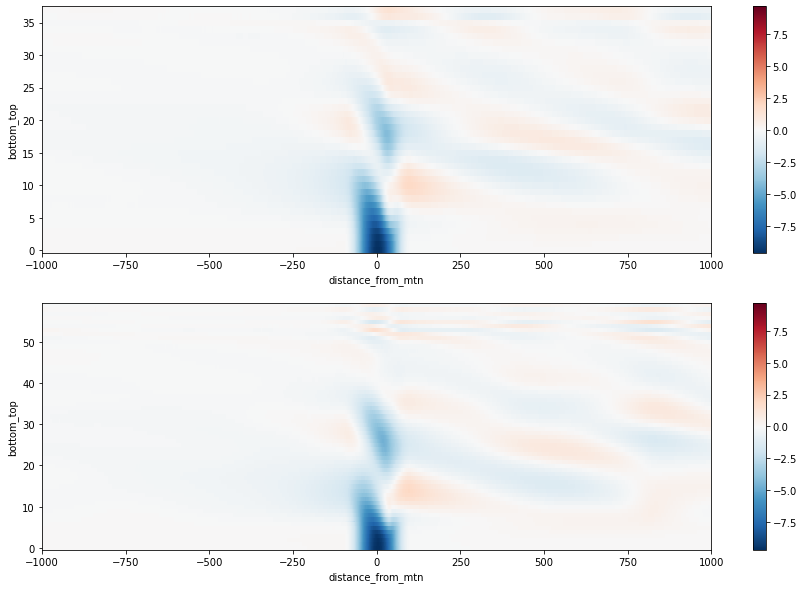

In [23]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(15,10))
(dryt_s-dryt_s[:,2200:3000].mean('distance_from_mtn')).plot(ax=ax)
(drydeept_s-drydeept_s[:,2200:3000].mean('distance_from_mtn')).plot(ax=ax2)
ax.set_xlim(-1000,1000)
ax2.set_xlim(-1000,1000)

In [27]:
%%time
dryq_s=change_coords_sfc(dryhrchannel.QVAPOR[201:].mean(['Time','south_north'])).load()
drydeepq_s=change_coords_sfc(drydeepchannel.QVAPOR[201:].mean(['Time','south_north'])).load()

CPU times: user 22 s, sys: 37.6 s, total: 59.6 s
Wall time: 54.9 s


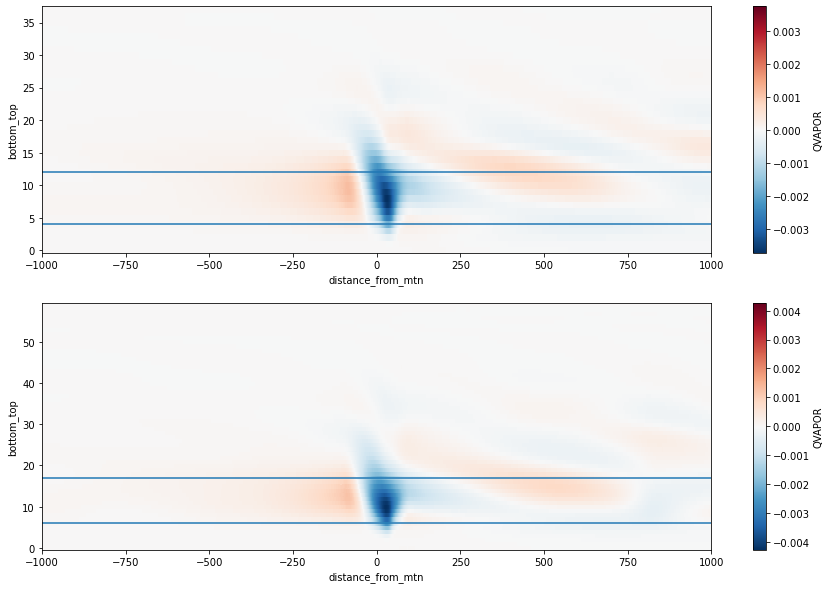

In [50]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(15,10))
(dryq_s-dryq_s[:,2200:3000].mean('distance_from_mtn')).plot(ax=ax)
(drydeepq_s-drydeepq_s[:,2200:3000].mean('distance_from_mtn')).plot(ax=ax2)
ax.set_xlim(-1000,1000)
ax2.set_xlim(-1000,1000)
ax.axhline(4)
ax.axhline(12)
ax2.axhline(6)
ax2.axhline(17)

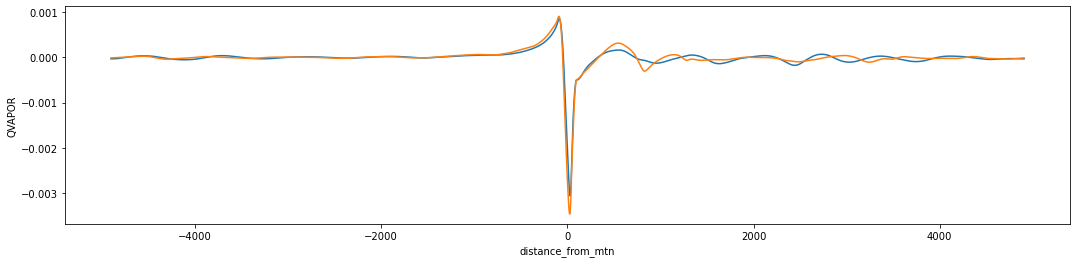

In [52]:
_,ax=plt.subplots(1,1,figsize=(18,4))
(dryq_s-dryq_s[:,2200:3000].mean('distance_from_mtn'))[4:12].mean('bottom_top').plot(ax=ax)
(drydeepq_s-drydeepq_s[:,2200:3000].mean('distance_from_mtn'))[6:17].mean('bottom_top').plot(ax=ax)

In [73]:
drydeepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/wrfinput_d01')
drydeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/')

In [74]:
plevs=np.array(deepchannel_p.P_PL.isel(Time=0).load())/100

In [91]:
sigmalev =change_coords_sfc(drydeepchannel.QVAPOR[300].mean('south_north')[6:17].mean('bottom_top'))
%time plev1 = change_coords_sfc(interp_eta_to_pressure_custom(drydeepchannel,drydeepchannel.QVAPOR[300].mean('south_north'),0,plevs,drydeepinput).sel(pressure=slice(700,900)).mean(['pressure']))
%time plev3 = interp_eta_to_pressure(drydeepchannel,change_coords_sfc(drydeepchannel.QVAPOR[300].mean('south_north')),0,plevs,drydeepinput).sel(pressure=slice(700,900)).mean(['pressure'])


CPU times: user 6.65 s, sys: 7.51 s, total: 14.2 s
Wall time: 9.7 s
CPU times: user 7.66 s, sys: 10.6 s, total: 18.3 s
Wall time: 10.4 s


In [117]:
from scipy.interpolate import interp1d
def interp_eta_to_pressure_custom(ds,var,staggered=1,plevs=None,dsinput=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    if dsinput is None:
        dsinput=ds
    rep=np.zeros((len(plevs),*var[0].shape))
    PB_rev = np.array(dsinput.PB[0,:,0]+ds.P[-1].mean(['south_north']))[::-1]
    test = dsinput.PB[0,:,0]+ds.P[-1].mean(['south_north'])
    test[:,1635].plot()
    test[:,0].plot()
    print(PB_rev.shape)
    var_rev=np.array(var)[::-1]
    for i in range(len(var[0])):
        f_out = interp1d(PB_rev[:,i], var_rev[:,i], axis=0)
        rep[:,i]=f_out(plevs*100)
        rep[plevs*100>PB_rev[-1,i],i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'south_north':var.south_north,'west_east':var.west_east},dims=['pressure','south_north','west_east'])

In [154]:
from scipy.interpolate import interp1d
def interp_eta_to_pressure_custom(ds,var,staggered=1,plevs=None,dsinput=None,PB_rev=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    if PB_rev is None:
        if dsinput is None:
            dsinput=ds
        PB_rev = np.array(dsinput.PB[0,:,0]+ds.P[-100:].mean(['Time','south_north']))[::-1]
    rep=np.zeros((len(plevs),*var[0].shape))
    var_rev=np.array(var)[::-1]
    if staggered:
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0,0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            f_out = interp1d(PB_rev_stag, var_rev[:,:,i], axis=0,bounds_error=False,fill_value=np.nan)
            rep[:,:,i]=f_out(plevs*100)
            rep[plevs*100>PB_rev[-1],:,i]=np.nan
    else:
        for i in range(len(var[0,0])):
            f_out = interp1d(PB_rev[:,i], var_rev[:,:,i], axis=0,bounds_error=False,fill_value=np.nan)
            rep[:,:,i]=f_out(plevs*100)
            rep[plevs*100>PB_rev[-1,i],:,i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'south_north':var.south_north,'west_east':var.west_east},dims=['pressure','south_north','west_east'])



In [155]:
PB_rev_test = np.array(drydeepinput.PB[0,:,0]+drydeepchannel.P[-10:].mean(['Time','south_north']))[::-1]
%time plev1 = change_coords_sfc(interp_eta_to_pressure_custom(drydeepchannel,drydeepchannel.QVAPOR[300],staggered=0,plevs=plevs,PB_rev=PB_rev_test).sel(pressure=slice(900,700)).mean(['pressure','south_north']))


CPU times: user 991 ms, sys: 83.5 ms, total: 1.07 s
Wall time: 1.07 s


In [ ]:
#p1 = dsinput.PB[0,:,0]drydeepchannel[-100:].mean(['Time','south_north']).load()

In [101]:
temp=drydeepchannel.QVAPOR[300].mean('south_north').load()

# Plots

In [35]:
deeppr=deepchannelprecip.isel(Time=slice(400,801)).mean(['Time','south_north']).load()
hrpr  =xr.open_dataarray("../../orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")

(-1000.0, 1000.0)

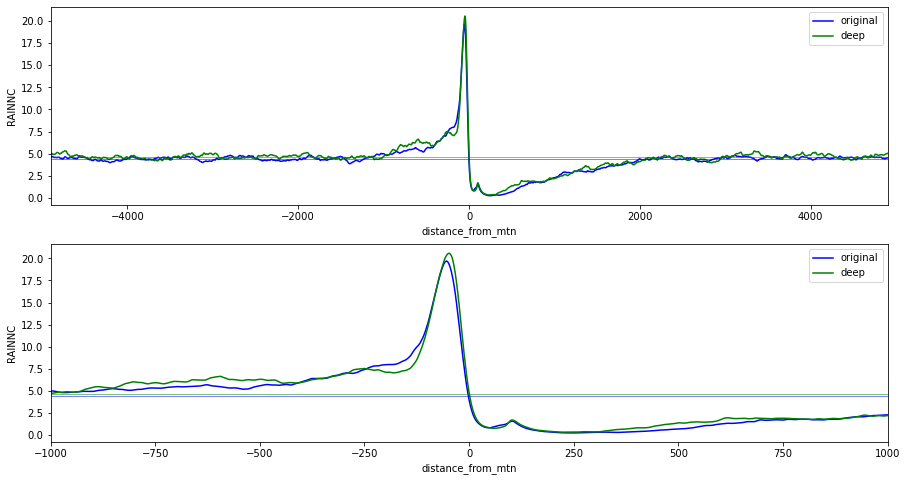

In [36]:
_,axs=plt.subplots(2,1,figsize=(15,8))
for ax in axs:
    change_coords_sfc(hrpr).plot(ax=ax,color='b',label='original')
    change_coords_sfc(deeppr).plot(ax=ax,color='g',label='deep')
    ax.axhline(hrpr[2000:3000].mean(),color='b',linewidth=0.5)
    ax.axhline(deeppr[2000:3000].mean(),color='g',linewidth=0.5)
    ax.legend()
    ax.set_xlim(-4900,4900)
ax.set_xlim(-1000,1000)

In [50]:
import wrf
def ztq(wrfinput,wrfrun):
    pressure =(wrfinput.PB[0,:,0,0]+wrfrun.P.mean(['south_north','west_east']))
    z_stag = (wrfinput.PHB[0,:,0,0]+wrfrun.PH.mean(['south_north','west_east']))/9.81
    z_destag = wrf.destagger(z_stag,0)
    theta = 300+wrfrun.T.mean(['south_north','west_east'])
    q = wrfrun.QVAPOR.mean(['south_north','west_east']).load()
    temp = (theta*(pressure/1e5)**0.286).load()
    
    return z_destag,temp,q

In [29]:
iss = range(0,1000,100)
zs = []
temps = []
qs = []
for i in iss:
    z_deep,temp_deep,q_deep = ztq(deepinput,deepchannel.isel(Time=i))
    zs.append(z_deep)
    temps.append(temp_deep)
    qs.append(q_deep)

In [21]:
z_stag_ref = (hrchannel.PHB[0,:,0,0]+hrchannel.PH[-40:].mean(['Time','south_north','west_east']))/9.81
z_ref  = wrf.destagger(z_stag_ref,0)
temp_ref = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc").mean(['west_east'])
q_ref = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc").mean(['west_east'])


In [ ]:
temp

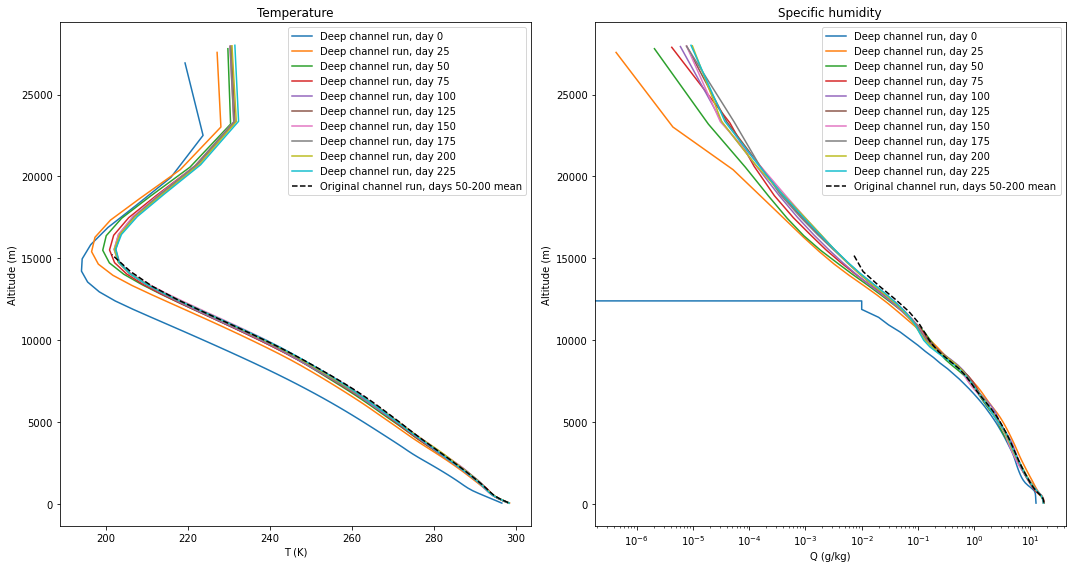

In [34]:
fig,axs=plt.subplots(1,2,figsize=(15,8))
ax=axs[0]
for i in iss:
    ax.plot(temps[i//100],zs[i//100],label="Deep channel run, day %i"%(i//4))
ax.plot(temp_ref,z_ref,color='k',linestyle='--',label="Original channel run, days 50-200 mean")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Temperature');ax.set_xlabel('T (K)')

ax=axs[1]
for i in iss:
    ax.plot(1e3*qs[i//100],zs[i//100],label="Deep channel run, day %i"%(i//4))
ax.plot(1e3*q_ref,z_ref,color='k',linestyle='--',label="Original channel run, days 50-200 mean")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Specific humidity');ax.set_xlabel('Q (g/kg)')
ax.set_xscale('log')

fig.tight_layout()

In [37]:
def plot_cdf(ax,values,lbl):
    """Values must be a 1D array sorted increasingly"""
    counts=np.arange(len(values))[::-1]
    select = np.concatenate([[0],np.where(values[1:]-values[:-1]>0)[0]])
    ax.plot(values[select],counts[select]/counts[0],label=lbl)

In [38]:
deepchannelprecip_hourly=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.hourly.days0-250.nc')
hrchannelprecip_hourly=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.hourly.days0-200.nc')


In [46]:
%%time
rce_deepchannelprecip_hourly_sorted = np.sort(np.array(deepchannelprecip_hourly[2400:,:,2200:3000]).reshape(-1))
rce_hrchannelprecip_hourly_sorted = np.sort(np.array(hrchannelprecip_hourly[1200:,:,2200:3000]).reshape(-1))

mtn_deepchannelprecip_hourly_sorted = np.sort(np.array(deepchannelprecip_hourly[2400:,:,1650:1655]).reshape(-1))
mtn_hrchannelprecip_hourly_sorted = np.sort(np.array(hrchannelprecip_hourly[1200:,:,1650:1655]).reshape(-1))


CPU times: user 21.6 s, sys: 9.85 s, total: 31.4 s
Wall time: 31.5 s


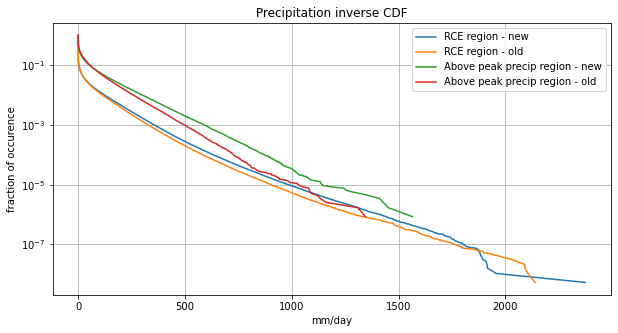

In [54]:
_,ax=plt.subplots(figsize=(10,5))
plot_cdf(ax,rce_deepchannelprecip_hourly_sorted,'RCE region - new')
plot_cdf(ax,rce_hrchannelprecip_hourly_sorted,'RCE region - old')

plot_cdf(ax,mtn_deepchannelprecip_hourly_sorted,'Above peak precip region - new')
plot_cdf(ax,mtn_hrchannelprecip_hourly_sorted,'Above peak precip region - old')

ax.set_yscale('log')
ax.set_title('Precipitation inverse CDF')
ax.set_xlabel('mm/day')
ax.set_ylabel('fraction of occurence')

ax.legend()
ax.grid()

In [48]:
%%time
deepchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')

rce_deepchannelprecip_sorted = np.sort(np.array(deepchannelprecip[400:,:,2200:3000]).reshape(-1))
rce_hrchannelprecip_sorted = np.sort(np.array(hrchannelprecip[200:,:,2200:3000]).reshape(-1))

mtn_deepchannelprecip_sorted = np.sort(np.array(deepchannelprecip[400:,:,1650:1655]).reshape(-1))
mtn_hrchannelprecip_sorted = np.sort(np.array(hrchannelprecip[200:,:,1650:1655]).reshape(-1))


CPU times: user 5.21 s, sys: 1.5 s, total: 6.71 s
Wall time: 9.09 s


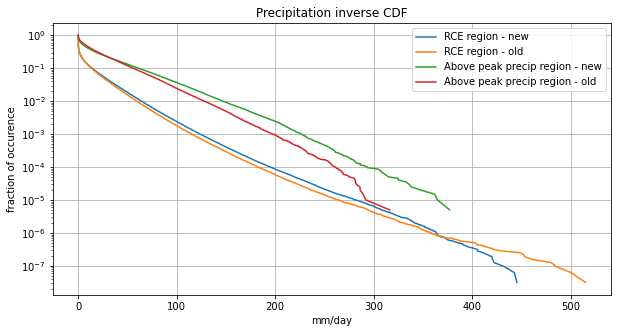

In [50]:
_,ax=plt.subplots(figsize=(10,5))
plot_cdf(ax,rce_deepchannelprecip_sorted,'RCE region - new')
plot_cdf(ax,rce_hrchannelprecip_sorted,'RCE region - old')

plot_cdf(ax,mtn_deepchannelprecip_sorted,'Above peak precip region - new')
plot_cdf(ax,mtn_hrchannelprecip_sorted,'Above peak precip region - old')


ax.set_yscale('log')
ax.set_title('Precipitation inverse CDF')
ax.set_xlabel('mm/day')
ax.set_ylabel('fraction of occurence')

ax.legend()
ax.grid()

# Energy budget

In [10]:
hrhfx  = xr.open_dataarray("../../orographicConvectionTheory/data/wrf.100x2.mountain.3km.HFX.days50-200.mean.nc")
hrradc = xr.open_dataarray("../../orographicConvectionTheory/data/wrf.100x2.mountain.3km.radiativecooling.days50-200.mean.nc")
hrevap = xr.open_dataarray("../../orographicConvectionTheory/data/wrf.100x2.mountain.3km.QFX.days50-200.mean.nc")

In [11]:
deephfx   = deepchannel.HFX.isel(Time=slice(400,1000)).mean(['south_north','Time']).persist()

In [12]:
%%time
def rad_cooling(sim,t1,t2):
    mSWUPT = (sim.ACSWUPT.isel(Time = t2)-sim.ACSWUPT.isel(Time = t1))/(t2-t1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = t2)-sim.ACSWDNT.isel(Time = t1))/(t2-t1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = t2)-sim.ACSWUPB.isel(Time = t1))/(t2-t1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = t2)-sim.ACSWDNB.isel(Time = t1))/(t2-t1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = t2)-sim.ACLWUPT.isel(Time = t1))/(t2-t1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = t2)-sim.ACLWDNT.isel(Time = t1))/(t2-t1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = t2)-sim.ACLWUPB.isel(Time = t1))/(t2-t1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = t2)-sim.ACLWDNB.isel(Time = t1))/(t2-t1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB
deepradc = rad_cooling(deepchannel,400,1000).mean(['south_north']).load()
deepevap = deepchannel.QFX.isel(Time=slice(400,1000)).mean(['south_north','Time']).load()

CPU times: user 1.42 s, sys: 5.16 s, total: 6.58 s
Wall time: 6.01 s


In [13]:
%%time
lmdeepradc = rad_cooling(lmdeepchannel,200,800).mean(['south_north']).load()
lmdeepevap = lmdeepchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).load()
lmdeephfx = lmdeepchannel.HFX.isel(Time=slice(200,800)).mean(['south_north','Time']).persist()


CPU times: user 1.86 s, sys: 57.4 s, total: 59.2 s
Wall time: 1min 49s


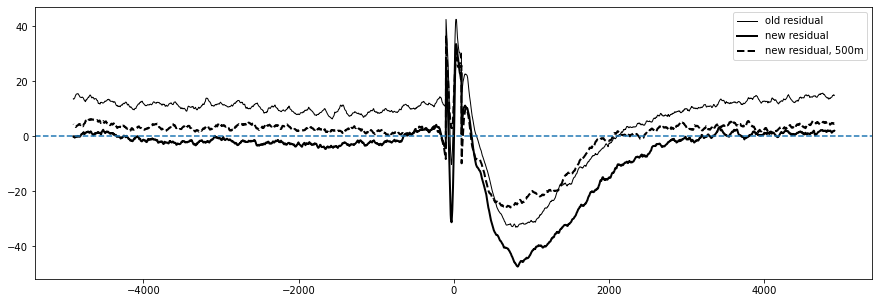

In [18]:
plt.figure(figsize=(15,5))
Lc=2.5e6
plt.plot(hrdist,Lc*hrevap+hrhfx-hrradc, label=r"old residual",color='k',linewidth=1)
plt.plot(hrdist,Lc*deepevap+deephfx-deepradc, label=r"new residual",color='k',linewidth=2)
plt.plot(hrdist,Lc*lmdeepevap+lmdeephfx-lmdeepradc, label=r"new residual, 500m",color='k',linestyle='--',linewidth=2)
plt.axhline(0.,linestyle='--')
plt.legend()

In [19]:
print("old residual: %.1f W/m2"      %(Lc*hrevap+hrhfx-hrradc            ).mean())
print("new residual: %.1f W/m2"      %(Lc*deepevap+deephfx-deepradc      ).mean())
print("new residual, 500m: %.1f W/m2"%(Lc*lmdeepevap+lmdeephfx-lmdeepradc).mean())

old residual: 5.6 W/m2
new residual: -6.5 W/m2
new residual, 500m: -0.0 W/m2


In [29]:
%time TG_timeseries = deepchannel.TG[:,:,1610:1660].mean(['south_north','west_east']).load()

CPU times: user 312 ms, sys: 2min 11s, total: 2min 11s
Wall time: 3min 20s


In [30]:
%time lmTG_timeseries = lmdeepchannel.TG[:,:,1610:1660].mean(['south_north','west_east']).load()

CPU times: user 337 ms, sys: 1min 6s, total: 1min 6s
Wall time: 1min 52s


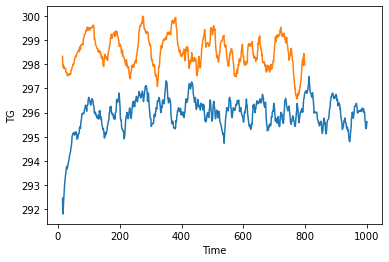

In [35]:
TG_timeseries.rolling(Time=16).mean().plot()
lmTG_timeseries.rolling(Time=16).mean().plot()

# Temperature profiles over precipitating times

In [55]:
%time deepchannel_p.T_PL[5280:6000:6].to_dataset().to_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_t_sub.zarr')

CPU times: user 2min 11s, sys: 13.8 s, total: 2min 25s
Wall time: 2min 22s


In [56]:
precip = deepchannelprecip[-121:-1]
precip_upstream = precip[:,:,2400:2600]
precip_mtn = precip[:,:,1640:1660]

temperature = xr.open_zarr('/global/cscratch1/sd/qnicolas/temp/wrf/deep_t_sub.zarr').T_PL
temperature=temperature.where(temperature>100)
temperature_upstream = temperature[:,:,:,2400:2600]
temperature_mtn = temperature[:,:,:,1640:1660]

In [57]:
meantemp_upstream = temperature_upstream.mean(['Time','south_north','west_east']).load()
meantemp_mtn = temperature_mtn.mean(['Time','south_north','west_east']).load()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [62]:
meantemp_upstream_precipitating = temperature_upstream.where(precip_upstream>2.).mean(['Time','south_north','west_east']).load()
meantemp_mtn_precipitating = temperature_mtn.where(precip_mtn>2.).mean(['Time','south_north','west_east']).load()


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [59]:
meantemp_upstream_precipitating2 = temperature_upstream[:-1].where(precip_upstream[1:]>2.).mean(['Time','south_north','west_east']).load()


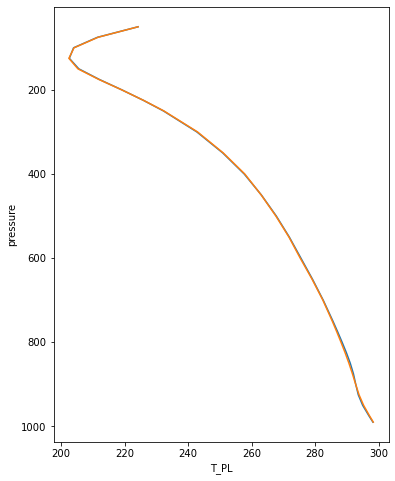

In [61]:
plt.figure(figsize=(6,8))
change_coords_press(deepchannel_p,meantemp_upstream).plot(y='pressure',yincrease=False)
change_coords_press(deepchannel_p,meantemp_upstream_precipitating).plot(y='pressure',yincrease=False)


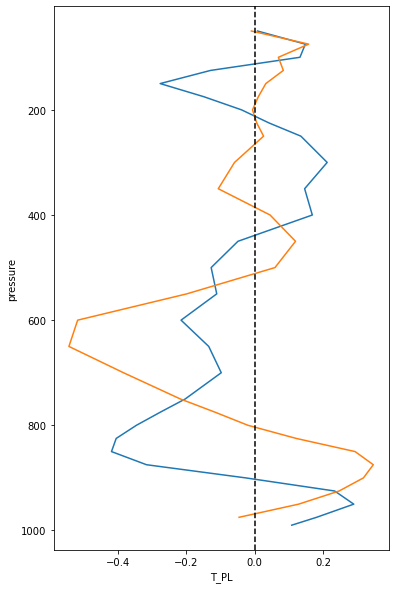

In [63]:
plt.figure(figsize=(6,10))
change_coords_press(deepchannel_p,meantemp_upstream_precipitating-meantemp_upstream).plot(y='pressure',yincrease=False )
change_coords_press(deepchannel_p,meantemp_mtn_precipitating-meantemp_mtn).plot(y='pressure',yincrease=False )

plt.axvline(0.,color='k',linestyle='--')

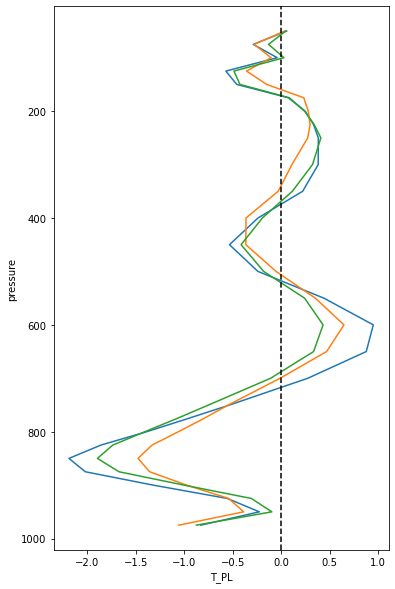

In [65]:
plt.figure(figsize=(6,10))
change_coords_press(deepchannel_p,meantemp_mtn-meantemp_upstream).plot(y='pressure',yincrease=False)
change_coords_press(deepchannel_p,meantemp_mtn_precipitating-meantemp_upstream_precipitating).plot(y='pressure',yincrease=False)
change_coords_press(deepchannel_p,meantemp_mtn_precipitating-meantemp_upstream).plot(y='pressure',yincrease=False)

plt.axvline(0.,color='k',linestyle='--')

# T_L - h_b covariation

## First thetae computation

In [10]:
from dask.distributed import Client
client = Client()

In [ ]:
%time T_bl = ((300+deepchannel.T[400:,0])*((deepinput.PB[0,0,0,:]+deepchannel.P[400:,0])/1e5)**0.286).mean(['Time','south_north']).load()
%time gz_bl = (deepinput.PHB[0,:2,0,:]+deepchannel.PH[400:,:2]).mean(['Time','south_north','bottom_top_stag']).load()
%time q_bl = deepchannel.QVAPOR[400:,0].mean(['Time','south_north']).load()
%time p_bl = (deepinput.PB[0,0,0,:]+deepchannel.P[400:,0]).mean(['Time','south_north']).load()

In [8]:
%time gz_bl = (deepinput.PHB[0,:2,0,:]+deepchannel.PH[400:,:2]).mean(['Time','south_north','bottom_top_stag']).load()

CPU times: user 9.84 s, sys: 1min 18s, total: 1min 28s
Wall time: 2min 5s


In [13]:
(deepinput.PHB[0,:4,0,0]+deepchannel.PH[400:,:4,:,0]).mean(['Time','south_north']).load()

<xarray.DataArray (bottom_top_stag: 4)>
array([   0.    , 1458.1053, 2933.3047, 4426.2373], dtype=float32)
Dimensions without coordinates: bottom_top_stag

In [14]:
(2933.3047+ 4426.2373)/2/9.81

375.10407747196734

In [35]:
%time T_bl = ((300+deepchannel.T[400:,:3])*((deepinput.PB[0,:3,0,:]+deepchannel.P[400:,:3])/1e5)**0.286).mean(['Time','south_north']).load()
%time gz_bl = wrf.destagger((deepinput.PHB[0,:4,0,:]+deepchannel.PH[400:,:4]).mean(['Time','south_north']).load(),0)
%time q_bl = deepchannel.QVAPOR[400:,:3].mean(['Time','south_north']).load()
%time p_bl = (deepinput.PB[0,:3,0,:]+deepchannel.P[400:,:3]).mean(['Time','south_north']).load()

CPU times: user 8.19 s, sys: 4.63 s, total: 12.8 s
Wall time: 41.8 s
CPU times: user 6.58 s, sys: 2.28 s, total: 8.85 s
Wall time: 37 s
CPU times: user 1.01 s, sys: 137 ms, total: 1.15 s
Wall time: 15.9 s
CPU times: user 5.89 s, sys: 2.67 s, total: 8.56 s
Wall time: 23.1 s


In [36]:
Td_bl = mpcalc.dewpoint_from_specific_humidity(np.array(q_bl), np.array(T_bl)*units.K, np.array(p_bl)*units.Pa)
zero_array = 0.*p_bl
thetae_bl = change_coords_sfc(zero_array+np.array(mpcalc.equivalent_potential_temperature(np.array(p_bl)*units.Pa,
                                                                        np.array(T_bl)*units.K,
                                                                        Td_bl
                                                                       )/units.K))
                                

In [9]:
tmean_p = xr.open_dataarray("../../orographicConvectionTheory/data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")

In [12]:
zero_array = 0.*tmean_p[:7]
thetaestar_L = 0.*tmean_p[:7] + np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(zero_array+tmean_p[:7].pressure)*units.hPa,
                                                                                       np.array(tmean_p[:7])*units.K
                                                                                      )/ units.K)


In [37]:
thetae_bl_prime = thetae_bl - thetae_bl[:,2200:2400].mean('distance_from_mtn')
thetaestar_L_prime = thetaestar_L - thetaestar_L[:,2200:2400].mean('distance_from_mtn')

In [42]:
thetae_bl_prime.mean('bottom_top').to_netcdf("/global/cscratch1/sd/qnicolas/temp/wrf/thetae_bl_prime_meanBL.nc")

In [43]:
thetaestar_L_prime.mean('pressure').to_netcdf("/global/cscratch1/sd/qnicolas/temp/wrf/thetaestar_L_prime_meanL.nc")

(-12.0, 15.0)

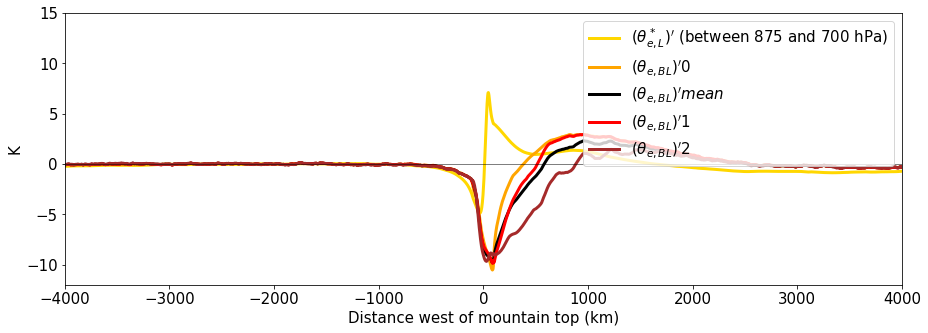

In [44]:
matplotlib.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=(15,5))

thetaestar_L_prime.mean('pressure').plot(   ax=ax,color='gold'  ,linewidth=3,label=r"$(\theta_{e,L}^*)'$ (between 875 and 700 hPa)")
thetae_bl_prime[0].plot(   ax=ax,color='orange'  ,linewidth=3,label=r"$(\theta_{e,BL})' 0$")
thetae_bl_prime.mean('bottom_top').plot(   ax=ax,color='k'  ,linewidth=3,label=r"$(\theta_{e,BL})' mean$")
thetae_bl_prime[1].plot(   ax=ax,color='red'  ,linewidth=3,label=r"$(\theta_{e,BL})' 1$")
thetae_bl_prime[2].plot(   ax=ax,color='brown'  ,linewidth=3,label=r"$(\theta_{e,BL})' 2$")

ax.axhline(0.,linestyle='-',linewidth='0.5',color='k')

ax.set_ylabel("K")
ax.legend()
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_title("")
ax.set_xlim(-4000,4000)
ax.set_ylim(-12,15)

## Computing thetae

In [5]:
from dask.distributed import Client
client=Client()

In [31]:
temp = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.TEMP.days100-250.nc") #Calculated by breaking down means of 50-day intervals
qvapor = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.QVAPOR.days100-250.nc")
gz = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.GEOPOTENTIAL.days100-250.nc")
pressure = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.PRESSURE.days100-250.nc")


In [ ]:
%time gz = wrf.destagger((deepinput.PHB[0,:,0,:]+deepchannel.PH[400:,:]).mean(['Time','south_north']).load(),0)
xr.DataArray(gz,coords=temp.coords,dims=temp.dims).to_netcdf("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.GEOPOTENTIAL.days100-250.nc")

In [28]:
%time (deepinput.PB[0,:,0,:]+deepchannel.P[400:,:]).mean(['Time','south_north']).to_netcdf("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.PRESSURE.days100-250.nc")


CPU times: user 13.3 s, sys: 2.95 s, total: 16.3 s
Wall time: 1min 22s


In [34]:
from tools.wrfHrTools import change_coords_sfc

In [44]:
temp_dew = mpcalc.dewpoint_from_specific_humidity(np.array(qvapor), np.array(temp)*units.K, np.array(pressure)*units.Pa)
zero_array = 0.*pressure
thetae = zero_array+np.array(mpcalc.equivalent_potential_temperature(np.array(pressure)*units.Pa,
                                                                        np.array(temp)*units.K,
                                                                        temp_dew
                                                                       )/units.K)
thetae.assign_attrs({'name':'Equivalent potential temperature on model levels','units':'K'}).to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.THETAE.days50-200.mean.nc")                     

In [49]:
thetae     = xr.open_dataarray("../../orographicConvectionTheory/data/wrf.100x2.mountain.3km.THETAE.days50-200.mean.nc")                     
thetae_bl = thetae[:3].mean("bottom_top")
thetae_bl_prime = thetae_bl - thetae_bl[2200:2400].mean('west_east')

In [45]:
tmean_p = xr.open_dataarray("../../orographicConvectionTheory/data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")

In [51]:
zero_array = 0.*tmean_p[:7]
thetaestar_L = 0.*tmean_p[:7] + np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(zero_array+tmean_p[:7].pressure)*units.hPa,
                                                                                       np.array(tmean_p[:7])*units.K
                                                                                      )/ units.K)
thetaestar_L_prime = thetaestar_L - thetaestar_L[:,2200:2400].mean('distance_from_mtn')

(-12.0, 15.0)

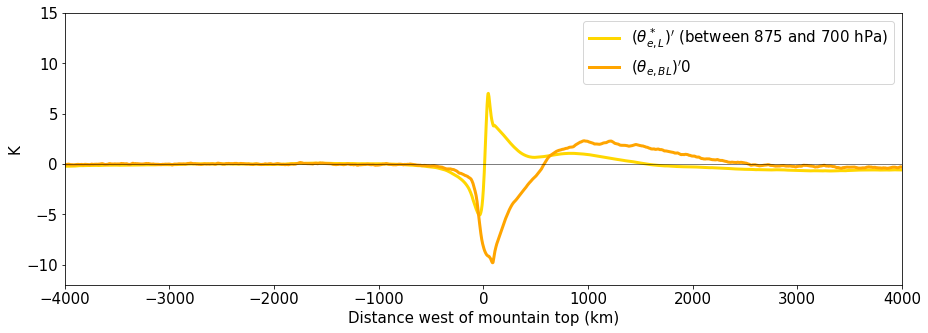

In [54]:
matplotlib.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=(15,5))

thetaestar_L_prime.mean('pressure').plot(   ax=ax,color='gold'  ,linewidth=3,label=r"$(\theta_{e,L}^*)'$ (between 875 and 700 hPa)")
change_coords_sfc(thetae_bl_prime).plot(   ax=ax,color='orange'  ,linewidth=3,label=r"$(\theta_{e,BL})' 0$")

ax.axhline(0.,linestyle='-',linewidth='0.5',color='k')

ax.set_ylabel("K")
ax.legend()
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_title("")
ax.set_xlim(-4000,4000)
ax.set_ylim(-12,15)